In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import warnings
warnings.filterwarnings('ignore')
import os
import glob
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my_geocoder")
import ast
import scipy.io
import cftime

In [2]:
#from Xiangtian Code
def shift_turbine_curve(turbine_curve, hub_height):
    """Shift a turbine curve based on a given hub height, x:wind speed, y: .
    :param pandas.Series turbine_curve: power curve data, wind speed index.
    :param float hub_height: height to shift power curve to.
    :param float maxspd: Extent of new curve (m/s).
    :param float new_curve_res: Resolution of new curve (m/s).
    """

    wspd_height_base_10m = 32.8084  # 10m in feet
    wspd_height_base_100m = 328.084  # 100m in feet
    wspd_height_base = 262.467  # 80m in feet
    wspd_exp = 0.15  # wspd(h) = wspd_0 * (h / h0)**wspd_exp
    new_curve_res = 0.01  # resolution: m/s
    offshore_hub_height = 393.701  # 120 meters, in feet
    max_wind_speed = 30  # m/s

    curve_x = np.arange(0, max_wind_speed + new_curve_res, new_curve_res)
    wspd_scale_factor = (wspd_height_base_100m / hub_height) ** wspd_exp
    turbine_curve_index = np.arange(0, 25.5, 0.5)
    
    shifted_x = turbine_curve_index * wspd_scale_factor
    r_df = turbine_curve.values
    turbine_curve_Val = r_df[0][1:]
    curve_x = curve_x.astype(float)
    shifted_x = shifted_x.astype(float)
    turbine_curve_Val = turbine_curve_Val.astype(float)
    shifted_curve = np.interp(curve_x, shifted_x, turbine_curve_Val , left=0, right=0)
    shifted_curve = pd.Series(data=shifted_curve, index=curve_x)
    shifted_curve.index.name = "Speed bin (m/s)"
    return shifted_curve

In [3]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
Data_directory = os.path.join(parent_directory, 'Data/NCFiles/Historical/')

dataHR = xr.open_dataset(Data_directory+'6CESM_HR_RCP85_ENS01_WindSpeed100m_2000_2020.nc')
lat_Value_HR = dataHR.coords['lat'].values
lon_Value_HR = dataHR.coords['lon'].values

dataLR = xr.open_dataset(Data_directory+'1CESM_LR_RCP85_ENS01_Climate-Power_CONUS_20002020.nc')
lat_Value_LR = dataLR.coords['lat'].values
lon_Value_LR = dataLR.coords['lon'].values

dataHR.close()
dataLR.close()

In [4]:
## Create Bias Correction df - ind: lon and col: lat
mat_data = scipy.io.loadmat(Data_directory + '/bias_correct_coefficients.mat')

bc_HR = mat_data['bc_HR']
bc_HR_df = pd.DataFrame(bc_HR)
bc_HR_df.columns = lat_Value_HR
bc_HR_df = bc_HR_df.set_index(lon_Value_HR)

bc_LR = mat_data['bc_LR']
bc_LR_df = pd.DataFrame(bc_LR)
bc_LR_df.columns = lat_Value_LR
bc_LR_df = bc_LR_df.set_index(lon_Value_LR)


In [5]:
def FilterTxFarms(address , filename):
    df = pd.read_excel(address+filename)
    new_column_names = df.iloc[0]
    df.columns = new_column_names
    filtered_df = df[df['State'].isin(['TX', 'Texas'])]
    filtered_df = filtered_df[['Utility Name', 'State',
       'County' , 'Nameplate Capacity (MW)',
       'Summer Capacity (MW)', 'Winter Capacity (MW)' , 'Predominant Turbine Manufacturer', 'Predominant Turbine Model Number' , 'Turbine Hub Height (Feet)']]
    filtered_file_path = address + '\WindFarmsTx.xlsx'  # Replace with the desired file path
    filtered_df.to_excel(filtered_file_path, index=False)
    return filtered_df

def FindCoordinate(name):
    name2 = name + ' County'
    location = geolocator.geocode(name2)
    return (location.latitude , location.longitude)

def FindNearestCoordinateLR(Coordinate_str):
    #lat_str, lon_str = Coordinate.strip("()").split(", ")
    Coordinate = tuple(eval(Coordinate_str))
    Lat = float(Coordinate[0])#lat_str)
    Lon = float(Coordinate[1])#lon_str)
    Est_Lat = round(Lat)
    Est_Lon = round(Lon)
    return (Est_Lat , Est_Lon)

def FindNearestCoordinateHR(Coordinate_str):
    #lat_str, lon_str = Coordinate.strip("()").split(", ")
    Coordinate = tuple(eval(Coordinate_str))
    Lat = float(Coordinate[0])#lat_str)
    Lon = float(Coordinate[1])#lon_str)
    Est_Lat = round(Lat * 4) / 4
    Est_Lon = round(Lon * 4) / 4
    return (Est_Lat , Est_Lon)

def PowerCalculation(WindSpeed):
    tmp_df = pd.DataFrame()
    tmp_df['Diff'] = abs(Curve.index - WindSpeed)
    closest_row = tmp_df['Diff'].idxmin()
    Ratio = Curve.iloc[closest_row]
    return Ratio*Capacity #Need **3?

In [6]:
file_path = parent_directory + "\Data"
if os.path.exists(Data_directory + "\WindFarmsTx.xlsx"):
    print("Filtered Tx Farm data exists!")
    TxFarmData = pd.read_excel(file_path + "\WindFarmsTx.xlsx")
else:
    TxFarmData = FilterTxFarms(file_path , "\WindFarms.xlsx")

In [7]:
## Finding Coordinates
if os.path.exists(file_path + "\WindFarmsTxCoordinated.xlsx"):
    print("Filtered Tx Farm data with Coordinates exists!")
    TxFarmData = pd.read_excel(file_path + "\WindFarmsTxCoordinated.xlsx")
else:
    TxFarmData['Coordinate'] = TxFarmData['County']
    TxFarmData['Coordinate'] = TxFarmData['Coordinate'].apply(FindCoordinate)
    TxFarmData.to_excel(file_path + "\WindFarmsTxCoordinated.xlsx", index=False)

Filtered Tx Farm data with Coordinates exists!


In [8]:
## Finding Nearest HR and LR node:
TxFarmData['NearestCoordinateLR'] = TxFarmData['Coordinate']
TxFarmData['NearestCoordinateLR'] = TxFarmData['NearestCoordinateLR'].apply(FindNearestCoordinateLR)
TxFarmData['NearestCoordinateHR'] = TxFarmData['Coordinate']
TxFarmData['NearestCoordinateHR'] = TxFarmData['NearestCoordinateHR'].apply(FindNearestCoordinateHR)

In [9]:
TurbineCurveDataset = pd.read_csv(parent_directory + '/Data/WindTurbinePowerCurves.csv')
NameColumn = 'Speed bin (m/s)'
directory_path = parent_directory + '/Data/NCFiles/Historical/'
file_list = os.listdir(directory_path)
LR_counter = 0
HR_counter = 0
for filename in file_list:
    full_path = os.path.join(directory_path, filename)
    if os.path.isfile(full_path)  and filename.lower().endswith('.nc'):
        df_time_generation = pd.DataFrame()
        print('Processing: ' + filename)
        if 'LR' in filename:
            LR_counter+=1
            output_name = 'LR' + str(LR_counter) + '.csv'
        elif 'HR' in filename:
            HR_counter+=1
            output_name = 'HR' + str(HR_counter) +'.csv'
        dataset = xr.open_dataset(full_path)

        for index, row in TxFarmData.iterrows():
            if 'LR' in filename:
                Lat_val , Lon_val = row.loc['NearestCoordinateLR']
                Coefficient = bc_LR_df.loc[(Lon_val+360) , (Lat_val)]
            elif 'HR' in filename:
                Lat_val , Lon_val = row.loc["NearestCoordinateHR"]
                Coefficient = bc_HR_df.loc[(Lon_val+360) , (Lat_val)]

            start_time = cftime.DatetimeNoLeap(2019, 1, 1) ##TODO: Convert leap years to non leap year or interpolate missing data
            end_time = cftime.DatetimeNoLeap(2019, 12, 31, 18, 0, 0)

            data = (dataset['WSPD100'].sel(lon = Lon_val+360, lat = Lat_val, method='nearest'))*Coefficient
            filtered_data = data.sel(time=slice(start_time, end_time))
            df = filtered_data.to_dataframe()
            TurbineModel =  (row.loc["Predominant Turbine Manufacturer"] + row.loc['Predominant Turbine Model Number']).lower().replace(' ', '')
            TurbineCurveDataset[NameColumn] = TurbineCurveDataset[NameColumn].str.lower().str.replace(' ', '')
            DefaultModel = 'iecclass2'
            if TurbineModel in TurbineCurveDataset[NameColumn].values:
                Curve_raw = TurbineCurveDataset[TurbineCurveDataset[NameColumn] == TurbineModel]
            else:
                Curve_raw = TurbineCurveDataset[TurbineCurveDataset[NameColumn] == DefaultModel]

            Capacity = row.loc['Nameplate Capacity (MW)']
            Height = row.loc['Turbine Hub Height (Feet)']
            Curve = shift_turbine_curve(Curve_raw, Height)
            df_time_generation[index] = df['WSPD100'].apply(PowerCalculation)
            
        df_time_generation.to_csv(parent_directory + '/Data/Generation/FarmBased/' + output_name, index=False)        

Processing: 1CESM_LR_RCP85_ENS01_Climate-Power_CONUS_20002020.nc
Processing: 2CESM_HR_RCP85_ENS02_WindSpeed100m_2000_2020.nc
Processing: 3CESM_LR_RCP85_ENS02_Climate-Power_CONUS_20002020.nc
Processing: 4CESM_LR_RCP85_ENS03_Climate-Power_CONUS_20002020.nc
Processing: 5CESM_LR_RCP85_ENS04_Climate-Power_CONUS_20002020.nc
Processing: 6CESM_HR_RCP85_ENS01_WindSpeed100m_2000_2020.nc


In [10]:
Gen_path = parent_directory + '/Data/Generation/'
file_list = os.listdir(Gen_path)
for filename in file_list:
    full_path = os.path.join(Gen_path, filename)
    if os.path.isfile(full_path) and filename.lower().endswith('.csv'):
        Generation = pd.read_csv(Gen_path + '/' + filename)
        county_groups = TxFarmData.groupby('County')
        county_indices = {}
        for county_name, group in county_groups:
            indices = group.index.tolist()
            county_indices[county_name] = indices

        summed_df = pd.DataFrame()
        start_time = pd.Timestamp("2019-01-01 00:00:00")
        end_time = pd.Timestamp("2019-12-31 18:00:00")
        time_range = pd.date_range(start=start_time, end=end_time, freq='6H')

        for county_name, indices in county_indices.items():
            summed_df[county_name] = Generation.iloc[:, indices].sum(axis=1)
        summed_df = summed_df.set_index(time_range)
        summed_df.to_csv(parent_directory + '/Data/Generation/summed/' + filename, index=False)        

In [16]:
Gen_path = parent_directory + '/Data/Generation/'
file_list = os.listdir(Gen_path)
AllGen_LR_df = pd.DataFrame()
AllGen_HR_df = pd.DataFrame()
for filename in file_list:
    full_path = os.path.join(Gen_path, filename)
    if os.path.isfile(full_path) and filename.lower().endswith('.csv'):
        print(filename)
        Generation = pd.read_csv(Gen_path + '/' + filename)
        start_time = pd.Timestamp("2019-01-01 00:00:00")
        end_time = pd.Timestamp("2019-12-31 18:00:00")
        time_range = pd.date_range(start=start_time, end=end_time, freq='6H')
        if 'LR' in filename:
            AllGen_LR_df = Generation.sum(axis=1)
            AllGen_LR_df.to_csv(parent_directory + '/Data/Generation/AllGen/AllGen_' + filename, index=False)  
        elif 'HR' in filename:
            AllGen_HR_df = Generation.sum(axis=1)
            AllGen_HR_df.to_csv(parent_directory + '/Data/Generation/AllGen/AllGen_' + filename, index=False) 

FarmBasedHR1.csv
FarmBasedHR2.csv
FarmBasedLR1.csv
FarmBasedLR2.csv
FarmBasedLR3.csv
FarmBasedLR4.csv


In [17]:
Gen_path = parent_directory + '/Data/Generation/AllGen/'
file_list = os.listdir(Gen_path)
AllGen_LR_Avg = pd.DataFrame()
AllGen_HR_Avg = pd.DataFrame()
concatenated_LR_df = pd.DataFrame()
concatenated_HR_df = pd.DataFrame()
for filename in file_list:
    full_path = os.path.join(Gen_path, filename)
    if os.path.isfile(full_path) and filename.lower().endswith('.csv'):
        if 'LR' in filename:
            df = pd.read_csv(full_path)  # Assuming 'timestamp' is the index column
            concatenated_LR_df = pd.concat([concatenated_LR_df, df], axis=1)
        if 'HR' in filename:
            df = pd.read_csv(full_path)  # Assuming 'timestamp' is the index column
            concatenated_HR_df = pd.concat([concatenated_HR_df, df], axis=1)

AllGen_HR_Avg = concatenated_HR_df.mean(axis=1)
AllGen_LR_Avg = concatenated_LR_df.mean(axis=1)
AllGen_LR_Avg.to_csv(parent_directory + '/Data/Generation/Avg/LR.csv', index=False)
AllGen_HR_Avg.to_csv(parent_directory + '/Data/Generation/Avg/HR.csv', index=False)

In [18]:
Gen_Directory = parent_directory + '/Data/Generation/'
Wind_LR_Data = Gen_Directory + '/Avg/LR.csv'
Wind_HR_Data = Gen_Directory + '/Avg/HR.csv'
ERCOT_Data = Gen_Directory + '/ERCOT/2019.csv'

LRGen = pd.read_csv(Wind_LR_Data)
HRGen = pd.read_csv(Wind_HR_Data)
ERCOTGen = pd.read_csv(ERCOT_Data)


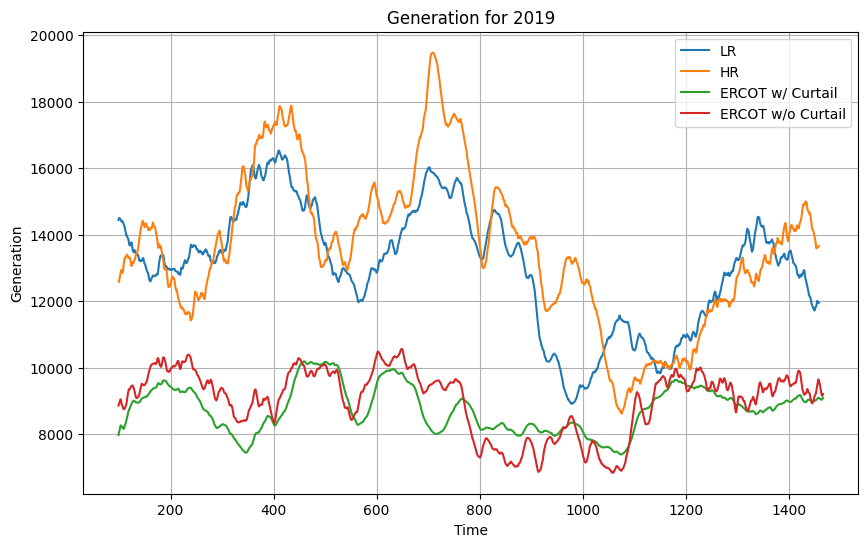

In [19]:
## Plot All Generation
plt.figure(figsize=(10, 6))
window_size = 100
LRGen_smoothed = LRGen.rolling(window=window_size).mean()
HRGen_smoothed = HRGen.rolling(window=window_size).mean()
ERCOTGen_smoothed = ERCOTGen.rolling(window=window_size).mean()

plt.plot( LRGen_smoothed, marker='', linestyle='-' , label='LR')
plt.plot( HRGen_smoothed, marker='', linestyle='-' , label='HR')
plt.plot( ERCOTGen_smoothed['ACTUAL_SYSTEM_WIDE'], marker='', linestyle='-' , label='ERCOT w/ Curtail')
plt.plot( ERCOTGen_smoothed['COP_HSL_SYSTEM_WIDE'], marker='', linestyle='-' , label='ERCOT w/o Curtail')

plt.title('Generation for 2019')
plt.xlabel('Time')
plt.ylabel('Generation')
plt.grid(True)
plt.legend() 
plt.show()